### Lab: Logistic Regression LDA, QDA, and KNN

#### The Stock Market Data
This data set consists of percentage returns for the S&P 500 stock index over 1, 250 days, from the beginning of 2001 until the end of 2005

###### Features 
* Lag1 through Lag5 - For each date,the percentage returns for each of the five previous trading days
* Volume - Number of shares traded on the previous day, in billions
* Today - Percentage return on the date in question

###### Response 
* Direction - Indicates whether the market was up or down on this date


### 1.Prepare Problem
#### a.Load libraries
#### b.Load dataset

In [1]:
from mlsettings.settings import load_app_config, get_datafolder_path
from mltools.mlcommon import load_data, print_dataset_info, split_dataset, auto_scatter_simple

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os.path
% matplotlib inline 
from numpy import set_printoptions
set_printoptions(precision=4)
pd.set_option('display.width', 120)
pd.set_option('precision', 4)

In [2]:
load_app_config()
DIRECTORY="islr"
FILENAME ='Smarket.csv'
RESPONSE="Direction"
input_path = get_datafolder_path()

{'UAT': {'ML_PATH': 'F:\\MachineLearning', 'ML_DATASOURCE': 'F:\\DataSource'}, 'PRD': {'ML_PATH': 'F:\\MachineLearning', 'ML_DATASOURCE': 'F:\\DataSource'}, 'DEV': {'ML_PATH': 'F:\\MachineLearning', 'ML_DATASOURCE': 'F:\\DataSource'}, 'REG': {'ML_PATH': 'F:\\MachineLearning', 'ML_DATASOURCE': 'F:\\DataSource'}}
Adding F:\MachineLearning  to system path
Adding F:\DataSource  to system path


In [3]:
def load_dataset(filename=FILENAME,response=RESPONSE):
    input_file = os.path.join(input_path, DIRECTORY, filename)
    input_dataset = load_data(input_file)
    print(" input file is :{0} loaded.".format(input_file))
    #print(input_dataset.head())
    
    try:
        continuous_vars = input_dataset.describe().columns
        print("Continous Variables")
        print(continuous_vars)
    except ValueError:
        print("No continous variables")
    
    try:
        categorical_vars = input_dataset.describe(include=["object"]).columns
        print("Categorical Variables")
        print(categorical_vars)
    except ValueError:
        print("No categorical variables")
        categorical_vars = None
    
    response_column =  [col for col in input_dataset.columns if response in col]
    feature_columns =  [col for col in input_dataset.columns if response not in col]
            
    
    return  input_dataset,feature_columns,response_column


In [4]:
input_dataset,feature_columns,response_column = load_dataset(filename=FILENAME,response=RESPONSE)
input_dataset = input_dataset.drop('Sno',axis=1)
feature_columns.remove('Sno')
X = input_dataset[feature_columns]
y = input_dataset[response_column]

 input file is :F:\DataSource\islr\Smarket.csv loaded.
Continous Variables
Index(['Sno', 'Year', 'Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume', 'Today'], dtype='object')
Categorical Variables
Index(['Direction'], dtype='object')


### 2.Summarize Data 
#### a) Descriptive statistics
#### b) Data visualizations

In [5]:
def display_data_descriptives(input_dataset,X,feature_columns,y,response_column):
    print("<{0} {1} {0}>".format("="*40,"feature columns"))
    print(feature_columns)
    print("<{0} {1} {0}>".format("="*40,"data header"))
    print(X.head().to_string())
    print("<{0} {1} {0}>".format("="*40,"response"))
    print(response_column)
    print("<{0} {1} {0}>".format("="*40,"Descriptive Statistics -X"))
    print(X.describe())
    print("<{0} {1} {0}>".format("="*40,"Descriptive Statistics -y"))
    print(y.describe())
    print("<{0} {1} {0}>".format("="*40,"value_count -y"))
    print(y.groupby(response_column)[response_column].count())
    #print(input_dataset.groupby(response_column)['Year'].count())
    print("<{0} {1} {0}>".format("="*40,"Correlation"))
    print(input_dataset.corr(method='pearson'))

In [6]:
display_data_descriptives(input_dataset,X,feature_columns,y,response_column)

<======================================== feature columns ========================================>
['Year', 'Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume', 'Today']
<======================================== data header ========================================>
   Year   Lag1   Lag2   Lag3   Lag4   Lag5  Volume  Today
0  2001  0.381 -0.192 -2.624 -1.055  5.010  1.1913  0.959
1  2001  0.959  0.381 -0.192 -2.624 -1.055  1.2965  1.032
2  2001  1.032  0.959  0.381 -0.192 -2.624  1.4112 -0.623
3  2001 -0.623  1.032  0.959  0.381 -0.192  1.2760  0.614
4  2001  0.614 -0.623  1.032  0.959  0.381  1.2057  0.213
<======================================== response ========================================>
['Direction']
<======================================== Descriptive Statistics -X ========================================>
           Year       Lag1       Lag2       Lag3       Lag4       Lag5     Volume      Today
count  1250.000  1250.0000  1250.0000  1250.0000  1250.0000  1250.0000  1250.0

In [7]:
def plot_hist(input_dataset,feature_columns,response_column,nbins=10):
    all_columns= feature_columns 
    fig = plt.figure(figsize=(16,20))
    rows,col = input_dataset.shape
    pal = sns.color_palette("colorblind",len(all_columns))
    colors =pal.as_hex()
    for i in range(col-1):
        ax = fig.add_subplot(4, 4, i+1)
        #ax.hist(input_dataset[all_columns[i]], bins=10, histtype='stepfilled')
        sns.distplot(input_dataset[all_columns[i]],ax=ax,kde=False,color =colors[i],norm_hist =True,hist_kws=dict(alpha=1))
        ax.set_title(all_columns[i])
    plt.tight_layout()

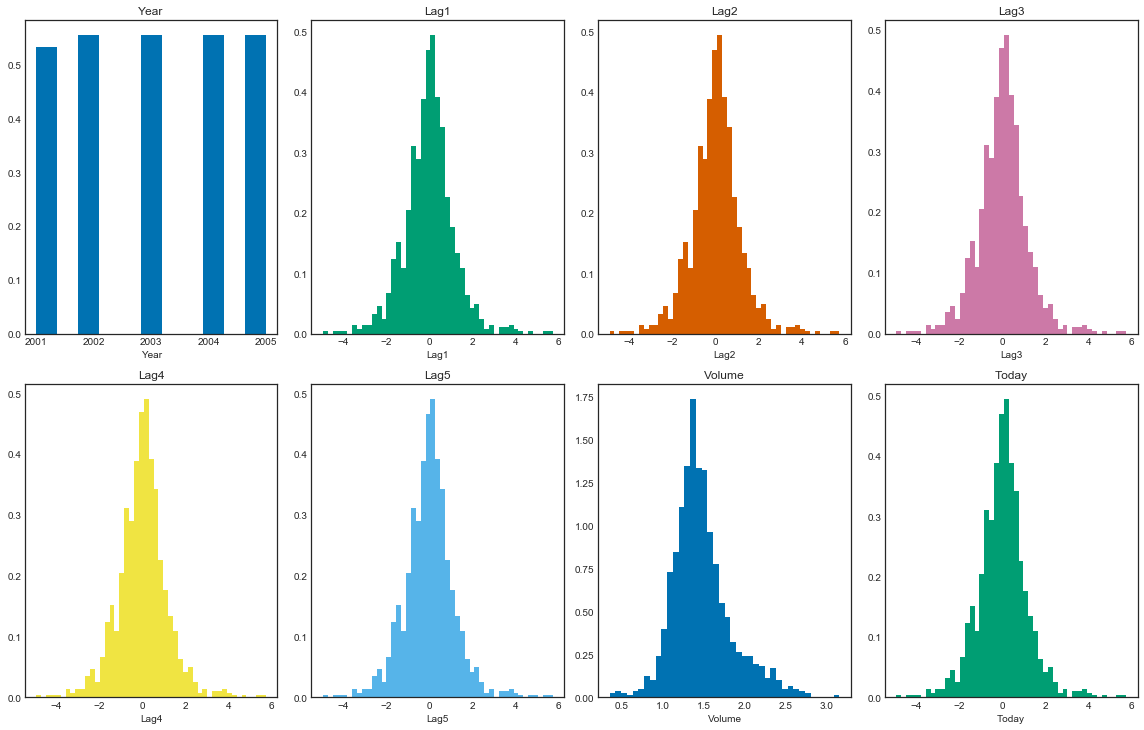

In [8]:
sns.set_style('white',{'axes.grid' : False})   
plot_hist(input_dataset,feature_columns,response_column,10)
#flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]

In [9]:
def plot_heatmap(input_dataset,feature_columns,response_column):
    sns.color_palette("Spectral")
    sns.set(font_scale=1.5)
    cm=input_dataset.corr('pearson')
    f, ax = plt.subplots(figsize=(12,9))
    hm = sns.heatmap(cm,cbar=True,annot=True,square=True,annot_kws={'size': 15},
                     yticklabels=feature_columns+response_column,xticklabels=feature_columns+response_column)
    plt.show()

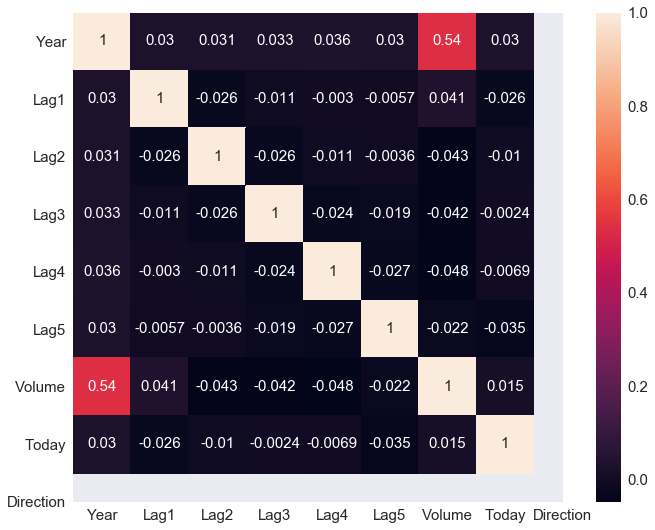

In [10]:
plot_heatmap(input_dataset,feature_columns,response_column)

---  
### 3. Prepare Data
#### a) Data Cleaning
#### b) Feature Selection
#### c) Data Transforms


In [11]:
from sklearn.preprocessing import LabelEncoder
class_le = LabelEncoder()
input_dataset['Direction'] = class_le.fit_transform(input_dataset['Direction'])
input_dataset.head(5)

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,2001,0.381,-0.192,-2.624,-1.055,5.010,1.1913,0.959,1
1,2001,0.959,0.381,-0.192,-2.624,-1.055,1.2965,1.032,1
2,2001,1.032,0.959,0.381,-0.192,-2.624,1.4112,-0.623,0
3,2001,-0.623,1.032,0.959,0.381,-0.192,1.2760,0.614,1
4,2001,0.614,-0.623,1.032,0.959,0.381,1.2057,0.213,1


 ### Feature selection 
Feature selection is a process where you automatically select those features in your data that contribute most to the prediction variable or output in which you are interested. Having irrelevant features in your data can decrease the accuracy of many models, especially linearalgorithms like linear and logistic regression.

#### Top reasons to use feature selection are:
It reduces the complexity of a model and makes it easier to interpret.

It improves the accuracy of a model if the right subset is chosen.

It reduces overfitting.

![alt text](../images/Feature_selection.png "Feature_selection")

In [12]:
from sklearn.ensemble import ExtraTreesClassifier
# feature extraction

def select_features_by_XTree(X,y):
    model = ExtraTreesClassifier()
    model.fit(X, y.values.ravel())

    selected_features =np.array(model.feature_importances_)
    selected_features_X = pd.DataFrame(X.columns.values, columns=['name'])
    selected_features =selected_features.reshape(8,1)

    selected_features_X['model_result'] =selected_features
    selected_features_X =selected_features_X.sort_values(by='model_result',ascending=False)
    return selected_features_X

In [13]:
print("<{0} {1} {0}>".format("="*40,"Feature Selection by XTree Classifier"))
features_XTree = select_features_by_XTree(X,y)
top_features =features_XTree['name']
top_features =list(top_features.values)
print(top_features)
top_features =top_features[1:6]
print(top_features)
 

<======================================== Feature Selection by XTree Classifier ========================================>
['Today', 'Lag2', 'Volume', 'Lag3', 'Lag5', 'Lag1', 'Lag4', 'Year']
['Lag2', 'Volume', 'Lag3', 'Lag5', 'Lag1']


In [14]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


from sklearn.model_selection  import  train_test_split
from sklearn.linear_model  import LogisticRegression

def evaluvate_pipeline(X_train,y_train,model,model_name):
    
    # create pipeline
    estimators =[]
    #estimators.append(('standardize', StandardScaler()))
    estimators.append((model_name, model))
    pipeline = Pipeline(estimators)
    # evaluate pipeline
    kfold = KFold(n_splits=10, random_state=7)
    scores = cross_val_score(pipeline, X_train, y_train.values.ravel(), cv=kfold)
    
    return scores,pipeline

In [15]:
from sklearn import metrics
def measure_performance(X, y, clf, show_accuracy=True,show_classification_report=True,
                        show_confusion_matrix=True, show_r2_score=False):
    y_pred = clf.predict(X) 
    if show_accuracy:
        print ("Accuracy:{0:.3f}".format( metrics.accuracy_score(y, y_pred)),"\n" )
    if show_classification_report:
        
        print ("Classification report")
        print (metrics.classification_report(y, y_pred),"\n")
    if show_confusion_matrix:
        print("Confusion matrix") 
        print(metrics.confusion_matrix(y, y_pred),"\n")
    if show_r2_score:
        print ("Coefficient of determination:{0:.3f}"
               .format( metrics.r2_score(y, y_pred)),"\n")
    return y_pred

In [16]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve,auc

from matplotlib import style

style.use('seaborn-colorblind')

def plot_roc(y_test, y_pred):
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    fig = plt.figure(figsize=(6,4))
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, 'b',label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.2])
    plt.ylim([-0.1,1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

    roc_auc_score(y_test, y_pred)


0.506617647059
Accuracy:0.583 

Classification report
             precision    recall  f1-score   support

          0       0.57      0.11      0.19        36
          1       0.58      0.94      0.72        48

avg / total       0.58      0.58      0.49        84
 

Confusion matrix
[[ 4 32]
 [ 3 45]] 



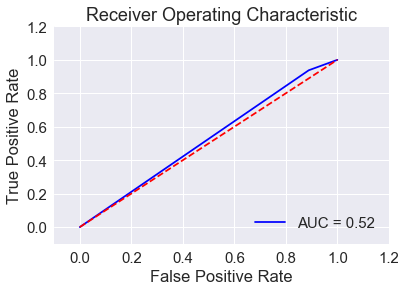

In [20]:
input_dataset =input_dataset[input_dataset['Year']==2005]
X = input_dataset[top_features]
y = input_dataset[response_column]
test_size = 0.33
seed = 7
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size,random_state=seed)
model =LogisticRegression()

scores,pipeline = evaluvate_pipeline(X_train,y_train,model,'log_reg')

print(scores.mean())

pipeline.fit(X_train,y_train.values.ravel())

y_pred = measure_performance(X_test,y_test,pipeline, show_accuracy=True, 
                    show_classification_report=True,
                    show_confusion_matrix=True, show_r2_score=False)
plot_roc(y_test, y_pred)

0.524469305795
Accuracy:0.530 

Classification report
             precision    recall  f1-score   support

          0       0.50      0.36      0.42       193
          1       0.55      0.68      0.61       220

avg / total       0.52      0.53      0.52       413
 

Confusion matrix
[[ 69 124]
 [ 70 150]] 



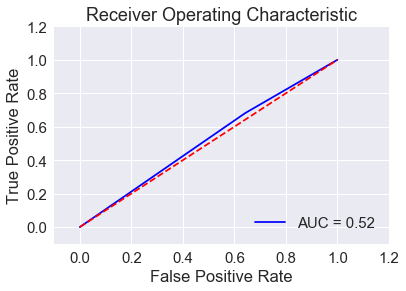

In [18]:
X = input_dataset[top_features]
y = input_dataset[response_column]
test_size = 0.33
seed = 7
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size,random_state=seed)
model =LinearDiscriminantAnalysis()

scores,pipeline = evaluvate_pipeline(X_train,y_train,model,'LDA')

print(scores.mean())

pipeline.fit(X_train,y_train.values.ravel())

y_pred = measure_performance(X_test,y_test,pipeline, show_accuracy=True, 
                    show_classification_report=True,
                    show_confusion_matrix=True, show_r2_score=False)
plot_roc(y_test, y_pred)